In [ ]:
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from S00_utils import plot_res, store_results

In [12]:
df = pd.read_excel("output/data_train_2.xlsx")
df = df.set_index("Unnamed: 0")
df.index.names = ["id"]
df.head()

,m1,m2,m3,s1__approximate_entropy__m_2__r_0.7,s1__autocorrelation__lag_9,s1__autocorrelation__lag_8,s1__autocorrelation__lag_7,s1__longest_strike_above_mean,s1__autocorrelation__lag_6,s1__autocorrelation__lag_5,...,"s1__agg_autocorrelation__f_agg_""mean""__maxlag_40",s1__ar_coefficient__coeff_10__k_10,"s1__fft_coefficient__attr_""abs""__coeff_4",s1__ar_coefficient__coeff_8__k_10,s1__approximate_entropy__m_2__r_0.5,"s1__fft_coefficient__attr_""abs""__coeff_3",s1__approximate_entropy__m_2__r_0.1,y1,y2,y3
id,,,,,,,,,,,,,,,,,,,,,
E001,187.616451,1415.961916,2.557955,0.185766,-0.212687,-0.016548,0.180225,16,0.369965,0.545277,...,0.111814,0.275924,9.657168,-0.129524,0.281910,7.000403,0.130575,68.601545,1.058818,88.361693
E002,101.574829,1155.296145,1.610162,0.201643,-0.337147,-0.130801,0.081408,15,0.289928,0.485372,...,0.073067,0.295375,4.576206,-0.127716,0.287208,3.997053,0.138715,53.906180,0.928938,120.448962
E003,105.981660,1354.421797,1.471213,0.280074,-0.724746,-0.519171,-0.277401,12,-0.016292,0.245955,...,-0.103510,0.311143,0.164255,-0.115387,0.295983,0.149326,0.160892,46.590224,1.356625,87.797819
E004,183.202078,1143.123554,2.027678,0.181729,-0.174395,0.019032,0.211732,16,0.396457,0.566256,...,0.116791,-0.191406,10.139354,0.064453,0.286139,8.100158,0.120629,68.758466,0.840078,118.543881
E005,190.252994,1018.419233,2.150465,0.247459,-0.562449,-0.349593,-0.116660,13,0.122974,0.355548,...,-0.045042,0.286307,12.336134,-0.121797,0.293460,10.561980,0.144695,61.326411,0.925232,70.486440


In [13]:
colsY = ["y1", "y2", "y3"]
colsX = [c for c in df.columns if c not in colsY]

X = df[colsX]
Y = df[colsY]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
print(Y_train.shape)

(70, 3)


In [14]:
scX = StandardScaler()
X_train_std = scX.fit_transform(X_train)
X_test_std = scX.transform(X_test)

scY = StandardScaler()
Y_train_std = scY.fit_transform(Y_train)
Y_test_std = scY.transform(Y_test)

In [15]:
paramSet = {
    "ex1": {"n_estimators": 10, "learning_rate": 1.0, "max_depth": 2},
    "ex2": {"n_estimators": 50, "learning_rate": 1.0, "max_depth": 3},
    "ex3": {"n_estimators": 50, "learning_rate": 1.0, "max_depth": 10},
    "ex4": {"n_estimators": 50, "learning_rate": 1.0, "max_depth": 1},
    "ex5": {"n_estimators": 100, "learning_rate": 1.0, "max_depth": 1},
    "ex6": {"n_estimators": 200, "learning_rate": 1.0, "max_depth": 1},
}

params = paramSet["ex4"]

In [16]:
base = GradientBoostingRegressor(**params)
regressor = MultiOutputRegressor(base)

In [17]:
regressor.fit(X_train_std, Y_train_std)
Y_train_pred = regressor.predict(X_train_std)
Y_test_pred = regressor.predict(X_test_std)

,MSE Train,MSE Test,R2 Train,R2 Test
0,0.001613,0.144960,0.998387,0.831469
1,0.001899,0.112517,0.998101,0.847848
2,0.001516,0.178103,0.998484,0.793466


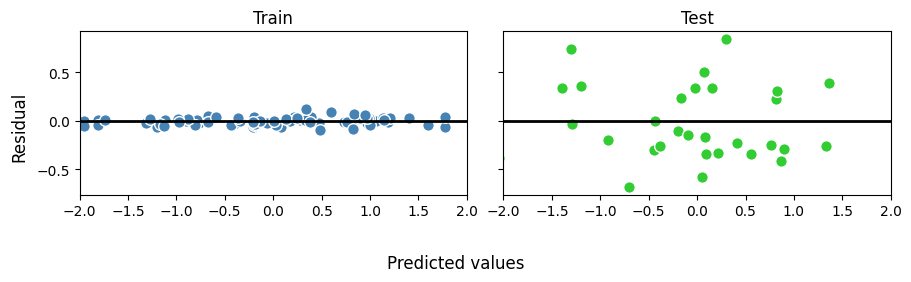

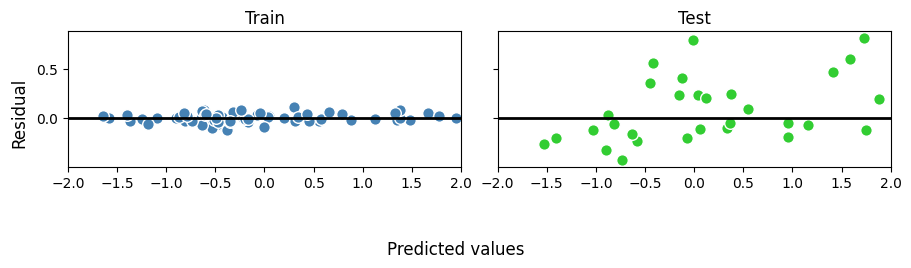

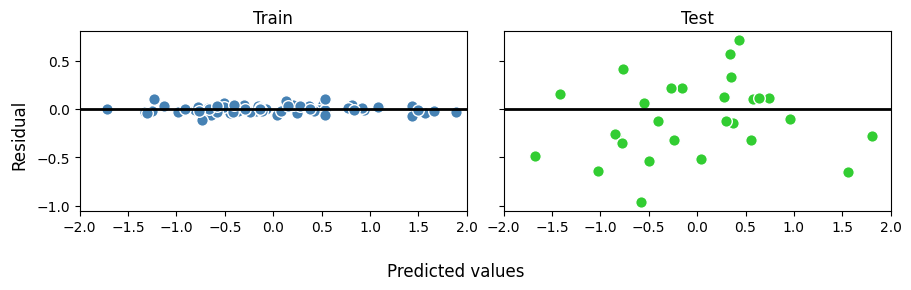

In [18]:
resArr = []
for i in range(Y.shape[1]):
    y_train = Y_train_std[:, i]
    y_test = Y_test_std[:, i]
    y_train_pred = Y_train_pred[:, i]
    y_test_pred = Y_test_pred[:, i]
    plot_res(y_train, y_test, y_train_pred, y_test_pred)
    res = store_results(y_train, y_test, y_train_pred, y_test_pred)
    resArr.append(res)

dfRes = pd.DataFrame.from_dict(resArr)
dfRes


In [19]:
dfFi = pd.DataFrame(data={"feature": X.columns.values})
estimators = regressor.estimators_
for i in range(len(estimators)):
    fi = estimators[i].feature_importances_
    dfFi[f"importance_{i+1}"] = fi

dfFi

,feature,importance_1,importance_2,importance_3
0,m1,0.177289,0.000221,0.000000
1,m2,0.000000,0.167739,0.006926
2,m3,0.001009,0.006512,0.303264
3,s1__approximate_entropy__m_2__r_0.7,0.618686,0.013590,0.000000
4,s1__autocorrelation__lag_9,0.091270,0.000000,0.000000
5,s1__autocorrelation__lag_8,0.000000,0.000000,0.000000
6,s1__autocorrelation__lag_7,0.000000,0.000000,0.000000
7,s1__longest_strike_above_mean,0.000000,0.000000,0.000000
8,s1__autocorrelation__lag_6,0.000000,0.000000,0.000000
9,s1__autocorrelation__lag_5,0.000000,0.000000,0.000000
